## HW02 Code

### Name: Jiawei Wang

You will complete the following notebook, as described in the PDF for Homework 02 (included in the download with the starter code).  You will submit:
1. This notebook file, along with your COLLABORATORS.txt file, to the Gradescope link for code.
2. A PDF of this notebook and all of its output, once it is completed, to the Gradescope link for the PDF.  (This can be generated by printing the notebook as PDF, or using the **File -> Download as** menu.)


Please report any questions to the [class Piazza page](https://piazza.com/tufts/spring2020/comp135/home).

In [1]:
# import libraries as needed
import numpy as np
import pandas as pd
import math

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

### Plotting function

**Do not modify the following**: it takes in a list of polynomial (integer) values, along with associated lists consisting of the predictions made for the associated model, and the resulting error, and plots the results in a grid.

In [2]:
def plot_predictions(polynomials=list(), prediction_list=list(), error_list=list()):
    '''Plot predicted results for a number of polynomial regression models
    
    Args
    ----
    polynomials : list of positive integer values
        Each value is the degree of a polynomial regression model.
    prediction_list: list of arrays ((# polynomial models) x (# input data))
        Each array contains the predicted y-values for input data.
    error_list: list of error values ((# polynomial models) x 1)
        Each value is the mean squared error (MSE) of the model with 
        the associated polynomial degree.
    
        Note: it is expected that all lists are of the same length, and 
            that this length be some perfect square (for grid-plotting).
    '''
    length = len(prediction_list)
    grid_size = int(math.sqrt(length))
    if not (length == len(polynomials) and length == len(error_list)):
        raise ValueError("Input lists must be of same length")
    if not length == (grid_size * grid_size):
        raise ValueError("Need a square number of list items (%d given)" % (length))
    
    fig, axs = plt.subplots(grid_size, grid_size, figsize =(14,14), sharey=True)
    for subplot_id, prediction in enumerate(prediction_list):
        # order data for display
        data_frame = pd.DataFrame(data=[x[:, 0], prediction]).T
        data_frame = data_frame.sort_values(by=0)
        x_sorted = data_frame.iloc[:, :-1].values
        prediction_sorted = data_frame.iloc[:, 1].values

        ax = axs.flat[subplot_id]
        ax.set_title('degree = %d; MSE = %.3f' % (polynomials[subplot_id], error_list[subplot_id]))
        ax.plot(x, y, 'r.')
        ax.plot(x_sorted, prediction_sorted, color='blue')
        
    plt.show()

### Load the dataset

In [3]:
data = pd.read_csv('data.csv')
data

,x_i,y_i
0,1.590909,2.846988
1,1.803030,2.959811
2,4.984848,13.041394
3,1.696970,3.971889
4,1.272727,2.454520
...,...,...
95,5.090909,11.537465
96,10.500000,10.381492
97,1.484848,2.683212
98,0.636364,1.437600


In [4]:
x = data.iloc[:, :-1].values
y = data.iloc[:, 1].values

### 1. Test a range of polynomial functions fit to the data

Fit models to data of polynomial degree $d \in \{1, 2, 3, 4, 5, 6, 10, 11, 12\}$.  For each such model, we will record its predictions on the input data, along with the mean squared error (MSE) that it makes.  These results are then plotted for comparison.

#### 1.1 Create function to generate models, make predictions, measure error.

In [5]:


def test_polynomials(polynomials=list()):
    '''Generates a series of polynomial regression models on input data.
       Each model is fit to the data, then used to predict values of that
       input data.  Predictions and mean squared error are collected and
       returned as two lists.
    
    Args
    ----
    polynomials : list of positive integer values
        Each value is the degree of a polynomial regression model, to be built.
    
    Returns
    -------
    prediction_list: list of arrays ((# polynomial models) x (# input data))
        Each array contains the predicted y-values for input data.
    error_list: list of error values ((# polynomial models) x 1)
        Each value is the mean squared error (MSE) of the model with 
        the associated polynomial degree.
    '''
    prediction_list = list()
    error_list = list()
   
    # TODO: fill in this function to generate the required set of models,
    #       returning the predictions and the errors for each.
    
   
    def prediction(i):
        poly = PolynomialFeatures(degree=i)
        xTrain = poly.fit_transform(x) # transform list x to assigned degree
        LinReg = linear_model.LinearRegression()
        LinReg.fit(xTrain, y)
        yTrainPredict = LinReg.predict(xTrain) # use the new list x with list y to generate regression function and give prediction
        return yTrainPredict
    
    for i in polynomials:
        result = prediction(i)
        prediction_list.append(result)
        MSE = mean_squared_error(y, result)
        error_list.append(MSE)
        
    return prediction_list, error_list

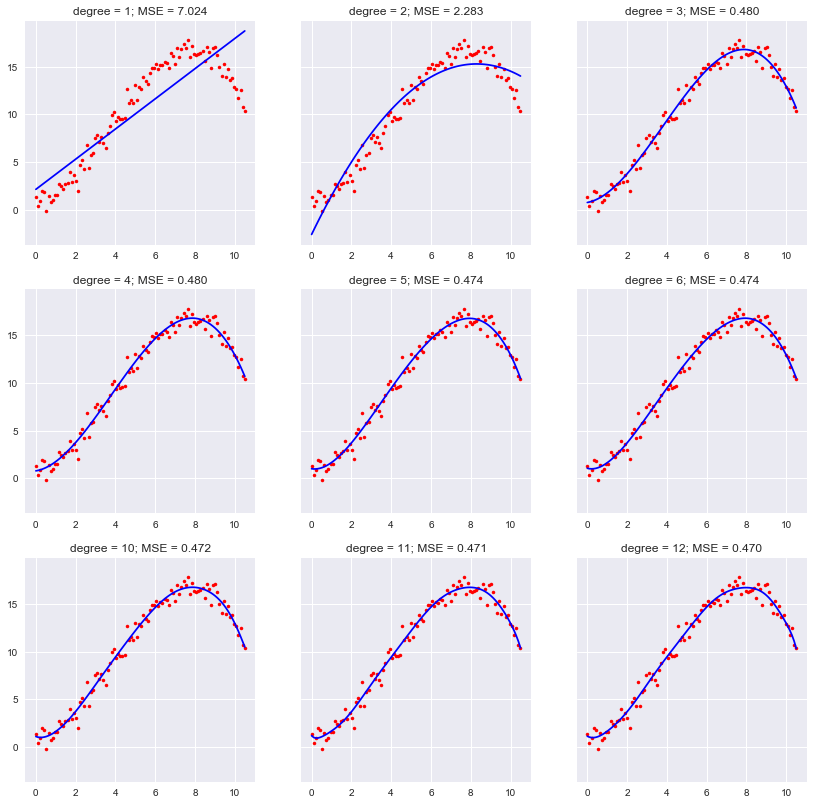

In [6]:
# TODO: generate the sequence of degrees, call test_polynomials to create models,
#       use plot_predictions to show the results

prediction_list, error_list = test_polynomials([1,2,3,4,5,6,10,11,12])
plot_predictions([1,2,3,4,5,6,10,11,12], prediction_list, error_list)

#### 1.2 Discuss the results seen in the plots above

**Discussion**:  The results show... (***TODO***)

Discuss the plotted results. What do they show? What is the best model, based
upon MSE? What models do particularly poorly? What does this tell you?

From Fig 1 to Fig 3 we can see that the line gradually matches the dots tighter, which gives us an idea that higher degree may provide predictions that fit better. 

Although from Fig 3 to Fig 9 this trend is not visible by eye, we can still see a decrease in MSE, which suggests that degree 12 may be the best among all 9. 

However, a lower MSE in training data does not necessary mean the MSE in testing data would also be lower, we still do not know whether the degree we set is underfitting or overfitting.

Degree 1 and degree 2 do particularly poorly because they have much higher MSE than other degrees so these results suggest that the actual function for (x, y) may not be a lower-order polynomial regression function, but rather more likely to be a higher-order one.


### 2. $k$-fold cross-validation 

For each of the polynomial degrees, 5-fold cross-validation is performed.  Data is divided into 5 equal parts, and 5 separate models are trained and tested.  Results are averaged over the 5 runs and plotted (in a single plot), comparing training and test error for each of the polynomial degrees.  Error values are also shown in a tabular form.

#### 2.1 Creating the $k$ folds

A function that generates the distinct, non-overlapping folds of the data.

In [7]:
def make_folds(num_folds=1):
    '''Splits data into num_folds separate folds for cross-validation.
       Each fold should consist of M consecutive items from the
       original data; each fold should be the same size (we will assume 
       that  the data divides evenly by num_folds).  Every data item should 
       appear in exactly one fold.
       
       Args
       ----
       num_folds : some positive integer value
           Number of folds to divide data into.
           
        Returns
        -------
        x_folds : list of sub-sequences of original x-data 
            There will be num_folds such sequences; each will 
            consist of 1/num_folds of the original data, in
            the original order.
        y_folds : list of sub-sequences of original y data
            There will be num_folds such sequences; each will 
            consist of 1/num_folds of the original data, in
            the original order.
       '''
    x_folds = list()
    y_folds = list()
    
    # TODO: Complete method to generate partition into folds.
    
    fold_size = int(len(x) / num_folds) # fold size for each fold
    for i in range(0, len(x), fold_size):
        x_folds.append(x[i : i+fold_size])
        y_folds.append(y[i : i+fold_size]) # divide list x and y into multiple sublists
        i += fold_size
    return x_folds, y_folds

In [8]:
# Print out start/end of each fold for sanity check.  Should see 5 folds,
# with the (x,y) pairs at the start/end of each.  (Can be manually verified 
# by looking at original input file.)
#
# DO NOT MODIFY THIS CODE.  Its output will be used to check your work.
k = 5
x_folds, y_folds = make_folds(k)
for i in range(k):
    print("Fold %d: (%.3f, %.3f) ... (%.3f, %.3f)"
         % (i, x_folds[i][0], y_folds[i][0], x_folds[i][-1], y_folds[i][-1]))

Fold 0: (1.591, 2.847) ... (10.394, 10.739)
Fold 1: (6.788, 16.408) ... (2.227, 4.722)
Fold 2: (9.545, 13.897) ... (3.924, 10.229)
Fold 3: (2.864, 5.929) ... (7.212, 16.030)
Fold 4: (7.530, 16.982) ... (0.848, 0.990)


#### 2.2 Perform cross-validation

For each of the polynomial degrees already considered, $k$-fold cross-validation is performed.  Average training error (MSE) and test error (MSE) are reported, both in the form of a plot and a tabular print of the values.

In [9]:
# TODO: Perform 5-fold cross-validation for each polynomial degree.  
#       Keep track of average training/test error for each degree; 
#       Plot results in a single table, properly labeled, and also
#       print out the results in some clear tabular format.


# This function separates the dataset into training and testing sets by index
def splitData(x, y, index):
    xTrain = np.delete(np.array(x), index, 0).reshape(-1,1)
    xTest  = x[index]
    yTrain = np.delete(np.array(y), index, 0).reshape(-1,1)
    yTest  = y[index]
    return xTrain, xTest, yTrain, yTest

In [10]:
from statistics import mean

# This function does k-fold cross-validation for every degree by returning training and testing MSE separately
def k_fold_cross_validation(x_folds, y_folds, polynomials):
    trainMSE = [[] for i in range(len(polynomials))]
    testMSE = [[] for i in range(len(polynomials))]  # training and testing MSE lists initialization, they are both 2D array
    num_folds = len(x_folds)
    for i, degree in enumerate(polynomials):
        for j in range(num_folds):
            poly = PolynomialFeatures(degree=degree)
            xTrain, xTest, yTrain, yTest = splitData(x_folds.copy(), y_folds.copy(), j)
            xTrain = poly.fit_transform(xTrain)
            xTest  = poly.fit_transform(xTest) # transform list x to assigned degree
            LinReg = linear_model.LinearRegression()
            LinReg.fit(xTrain, yTrain)
            yTrainPredict = LinReg.predict(xTrain)
            yTestPredict  = LinReg.predict(xTest)
            trainMSE[i].append(mean_squared_error(yTrain, yTrainPredict))
            testMSE[i].append(mean_squared_error(yTest, yTestPredict)) 
        trainMSE[i] = mean(trainMSE[i])
        testMSE[i]  = mean(testMSE[i]) # calculate average MSE for every row and transform 2D array into 1D 
    return trainMSE, testMSE

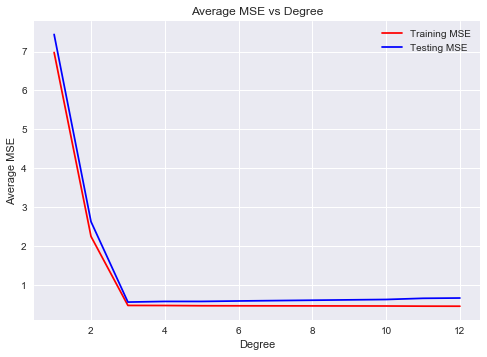

In [11]:
x_folds, y_folds = make_folds(5)
trainMSE, testMSE = k_fold_cross_validation(x_folds, y_folds, [1,2,3,4,5,6,10,11,12])

plt.plot([1,2,3,4,5,6,10,11,12], trainMSE, color='red', label="Training MSE")
plt.plot([1,2,3,4,5,6,10,11,12], testMSE, color='blue', label="Testing MSE")
plt.legend()
plt.title('Average MSE vs Degree')
plt.xlabel('Degree')
plt.ylabel('Average MSE')
plt.show()

In [12]:
print('Training MSE list:')
print('--------------------------------------------------------------------------------')
print(trainMSE)
print('--------------------------------------------------------------------------------')
print('Testing MSE list:')
print('--------------------------------------------------------------------------------')
print(testMSE)
print('--------------------------------------------------------------------------------')

Training MSE list:
--------------------------------------------------------------------------------
[6.977640618384499, 2.245920078402712, 0.4716205597489325, 0.46990922272557756, 0.4636631806054689, 0.46206862640077734, 0.4571990531646934, 0.453293842006307, 0.4518911647194181]
--------------------------------------------------------------------------------
Testing MSE list:
--------------------------------------------------------------------------------
[7.44115651272561, 2.625608154791989, 0.5580828437253424, 0.5746231833029637, 0.574579627173667, 0.5866062520190173, 0.624747792512756, 0.6549508509446084, 0.6625331491779624]
--------------------------------------------------------------------------------


#### 2.3 Discuss the results seen in the plots above

**Discussion:** The results show... (***TODO***)

Discuss the plotted results. What do they show? Where do we see the best
results? Where is their underfitting, and why do you say that? Where is there overfitting,
and why do you say that?

The plotted results show that both training and testing MSE drops quickly with the increase in degree from 1 to 3, which supports my guess in question 1.2 that degree 1 and 2 are poorly fitted, and also we can tell that they are actually underfitted.

However starting from degree 3, the gap between testing MSE and training MSE slightly increases which suggests that we are overfitting the function by giving degrees that are larger than 3. So 3 maybe the best degree for this function with both low MSE and also minimum gap.

### 3. Higher-order polynomials

Results are generated and plotted (as for part 1), for the higher polynomial degrees $d = \{15, 17, 19, 21, 25, 30, 35, 40, 50\}$.

#### 3.1 Plot a grid of prediction results/errors for the higher-order polynomials

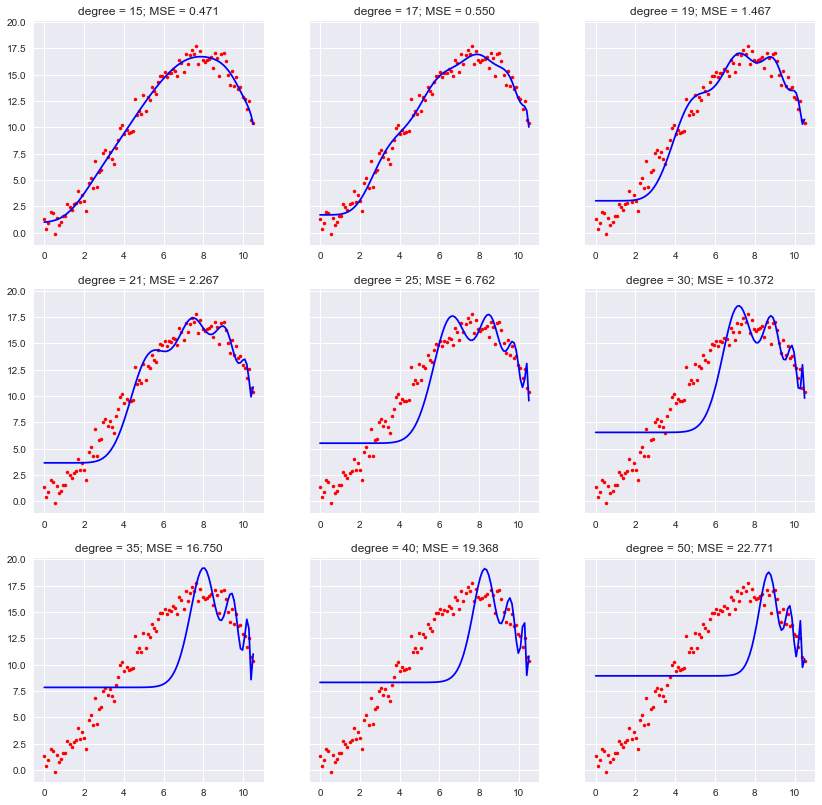

In [13]:
# TODO: generate and plot 9 more models, for the higher-degree polynomials indicated.

prediction_list, error_list = test_polynomials([15,17,19,21,25,30,35,40,50])
plot_predictions([15,17,19,21,25,30,35,40,50], prediction_list, error_list)

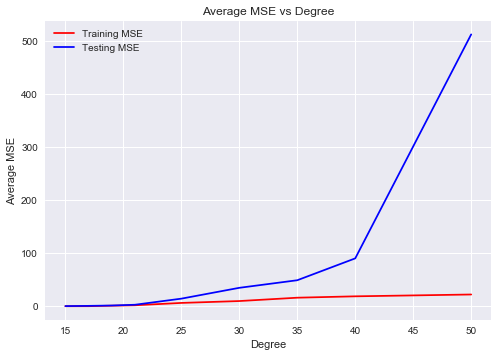

In [14]:
x_folds, y_folds = make_folds(5)
trainMSE, testMSE = k_fold_cross_validation(x_folds, y_folds, [15,17,19,21,25,30,35,40,50])

plt.plot([15,17,19,21,25,30,35,40,50], trainMSE, color='red', label="Training MSE")
plt.plot([15,17,19,21,25,30,35,40,50], testMSE, color='blue', label="Testing MSE")
plt.legend()
plt.title('Average MSE vs Degree')
plt.xlabel('Degree')
plt.ylabel('Average MSE')
plt.show()

#### 3.2 Discuss the results seen in the plots above

**Discussion**: The results show... (***TODO***)

Discuss the plotted results. What do they show us, and why do you think they
look the way they do? (You will want to do a little research online or otherwise to help
you answer this question.)

The results in the plots show that testing MSE increases with the increase in degree, which is just the same as expected. The more we overfit the model, the bigger testing MSE should be.

However, it is unclear why training also increases with the increase in degree because when we overfit the model, the prediction line should be closer to the dots so training MSE should be smaller. 

So maybe one answer to this is the sklearn.linear_model.LinearRegression() does not work properly when we set the degree too high and therefore bigger errors are made.

### 4. Regularized (ridge) regression

Ridge regularization is a process whereby the loss function that is minimized combines the usual measure (error on the training data) with a penalty that is applied to the magnitude of individual coefficients.  This latter penalty discourages models that overly emphasize any single feature, and can often prevent over-fitting.

Here, a set of 50 different `sklearn.linear_model.Ridge` models are generated, each using a single polynomial degree (the one that was determined to be best for the data-set in earlier tests), and using a range of different regularization penalties, chosen from a logarithmic series: $s \in [0.01, 100]$.  5-fold cross-validation is again used to examine how robust these models are.

#### 4.1 Cross-validation for each regularization strength value

In [15]:
# TODO: Generate a sequence of 50 ridge models, varying the regularization strength
#       from 0.01 (10^-2) to 100 (10^2).  Each model is 5-fold cross-validated and
#       the resulting average training/test errors are tracked.  Errors are then
#       plotted (on a logarithmic scale) and printed in some legible tabular form.


import operator
from sklearn.linear_model import Ridge


# Split the x and y datasets and generate xTrain and yTrain sets using 5 folds
xTrains=[]
yTrains=[]
fold_size = int(len(x) / 5)
index = 0
for i in range(5):
    rows = [ i for i in range(index, index+fold_size)]
    xTrains.append(np.delete(x,rows,0))
    yTrains.append(np.delete(y,rows,0))
    index += fold_size

In [16]:
# Ridge regression implementation
#  I finished this part with help from TA and my friends because I had some trouble understanding how ridge regression works
def ridgeRegression(xTrains ,yTrains ,degree ,regularization):
    testErrors = []
    trainErrors = []
    for alpha in regularization:
        testError = 0
        trainError = 0
        for i in range(5):
            xTrain = tuple(xTrains[i])
            yTrain = tuple(yTrains[i])
            xTest = tuple(x_folds[i])
            yTest = tuple(y_folds[i])
            sorted_zip = sorted(zip(xTrain, yTrain), key=operator.itemgetter(0))
            xTrain, yTrain = zip(*sorted_zip)
            poly = PolynomialFeatures(degree)
            xTrainPoly = poly.fit_transform(xTrain)
            xTestPoly = poly.fit_transform(xTest)
            ridgeRegressionPoly = Ridge(alpha)
            ridgeRegressionPoly.fit(xTrainPoly,yTrain)
            yTestPredict = ridgeRegressionPoly.predict(xTestPoly)
            yTrainPredict = ridgeRegressionPoly.predict(xTrainPoly)
            testError += mean_squared_error(yTest, yTestPredict)
            trainError += mean_squared_error(yTrain,yTrainPredict)
        testErrors.append(testError / k)
        trainErrors.append(trainError / k)
    return testErrors,trainErrors

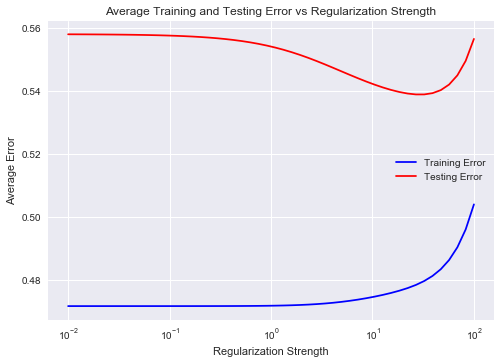

In [17]:
# Print the result
degree = 3
regularization = np.logspace(-2, 2, base=10, num=50)
testErrors,trainErrors = ridgeRegression(xTrains,yTrains,degree,regularization)


from matplotlib import pyplot
pyplot.xscale('log')
plt.plot(regularization,trainErrors, color='blue', label="Training Error")
plt.plot(regularization,testErrors, color='red', label="Testing Error")
plt.title('Average Training and Testing Error vs Regularization Strength')
plt.xlabel('Regularization Strength')
plt.ylabel('Average Error')
plt.legend()
plt.show()

#### 4.2 Discuss the results seen in the plots above

**Discussion**:  The results show...  (***TODO***)

Discuss the plotted results. Where is the effect of increasing regularization
strength helpful in avoiding overfitting, does it appear, and why do you say that? Where
is the effect less useful, and why do you say that?


Regularization is a form of regression that constrains/ regularizes or shrinks the coefficient estimates towards zero. In other words, this technique discourages learning a more complex or flexible model, so as to avoid the risk of overfitting. When we regularize the coefficient estimates, the line will be more loose (not tightly close to the testing dots), but it will give a better prediction on testing data.

So that means when we increase the regularization strength, we will make the line less loose, and therefore cause two things:

1. the line becomes more loose, which helps reduce the risk of overfitting but will increase the training error. And that is the same as shown in the graph.
2. a more loose line helps make better prediction on testing data overall, and we can also see that in the graph: when strength goes up, the testing error goes down. However, at about strength = 10^1.5 the error goes up again and this indicates us that we have gone too far and is underfitting the data.